# Importing libraries and loading annotations from the CSV file

In [2]:
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from shutil import copyfile
from ultralytics import YOLO

import pandas as pd

# Load annotations
df = pd.read_csv('train.csv')

# Mapping class names and filtering for valid classes.

In [3]:
convert_to_face_no_mask = ['face_other_covering', 'scarf_bandana', 'face_shield', 'hijab_niqab']
convert_to_face_with_mask = [
    'face_with_mask_incorrect', 'balaclava_ski_mask', 'face_other_covering', 
    'mask_colorful', 'mask_surgical', 'gas_mask'
]

# Convert classes based on the given rules
df['classname'] = df['classname'].apply(lambda x: 'face_no_mask' if x in convert_to_face_no_mask else ('face_with_mask' if x in convert_to_face_with_mask else x))

# Keep only face_with_mask and face_no_mask classes
valid_classes = ['face_with_mask', 'face_no_mask']
df = df[df['classname'].isin(valid_classes)]

# Mapping class names to numeric labels.

In [4]:
class_map = {'face_no_mask': 0, 'face_with_mask': 1}
df['label'] = df['classname'].map(class_map)

# Visualizing sample images with bounding boxes for each unique class.

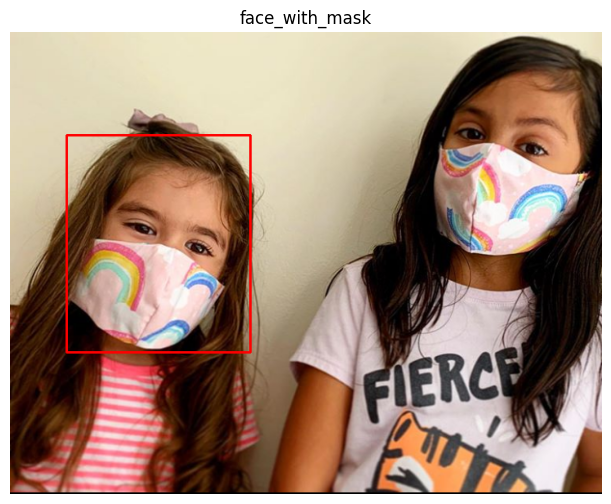

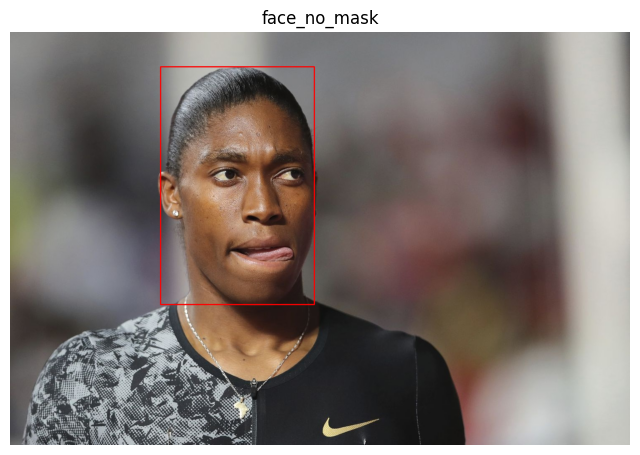

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os



# Define the image directory
image_dir = 'images'

# Get unique class names
unique_classnames = df['classname'].unique()

# Loop through each unique class and plot one image
for classname in unique_classnames:
    # Get one sample for the current class
    sample = df[df['classname'] == classname].iloc[0]
    
    # Load the image
    img_name = sample['name']
    img_path = os.path.join(image_dir, img_name)
    image = cv2.imread(img_path)
    if image is None:
        print(f"Error loading image {img_name}")
        continue
    
    # Convert color for plotting
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Get bounding box
    xmin, ymin, xmax, ymax = sample['x1'], sample['x2'], sample['y1'], sample['y2']
    
    # Plot bounding box
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
    
    # Plot the image
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(classname)
    plt.axis('off')
    plt.show()


In [8]:
df

,name,x1,x2,y1,y2,classname,label
0,2756.png,69,126,294,392,face_with_mask,1
1,2756.png,505,10,723,283,face_with_mask,1
2,2756.png,75,252,264,390,face_with_mask,1
3,2756.png,521,136,711,277,face_with_mask,1
4,6098.jpg,360,85,728,653,face_no_mask,0
...,...,...,...,...,...,...,...
15405,2460.png,650,5,805,184,face_no_mask,0
15407,1894.jpg,437,121,907,644,face_with_mask,1
15408,1894.jpg,557,363,876,636,face_with_mask,1
15410,3216.png,126,69,409,463,face_with_mask,1


# Displaying an image with bounding boxes and labels for annotations.

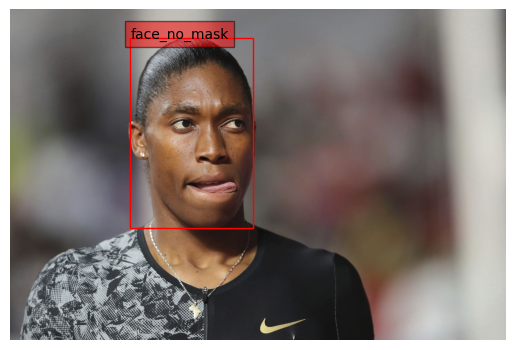

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2


# Choose the image filename
image_filename = '6098.jpg'

# Filter annotations for the chosen image
fd = df[df['name'] == image_filename]

# Construct the full image path
image_path = f'images/{image_filename}'  # Adjust path based on your file structure

# Load the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Create figure and axes
fig, ax = plt.subplots(1)
ax.imshow(image)

# Plot each annotation for the chosen image
for index, row in fd.iterrows():
    class_name = row['classname']
    xmin, ymin, xmax, ymax = row['x1'], row['x2'], row['y1'], row['y2']
    
    width = xmax - xmin
    height = ymax - ymin

    # Create a rectangle patch
    rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the plot
    ax.add_patch(rect)
    
    # Add label if needed
    plt.text(xmin, ymin, class_name, fontsize=10, bbox=dict(facecolor='red', alpha=0.5))

# Show the plot
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()


# Converting and visualizing image annotations in YOLO format

In [5]:
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Define the image and annotation paths
image_dir = 'images'
labels_dir = 'labels'


# Choose a single image to process (you can change the index as needed)
img_name = df['name'].iloc[0]


img_path = os.path.join(image_dir, img_name)
annotations = df[df['name'] == img_name]

# Load the image
image = cv2.imread(img_path)
if image is None:
    print(f"Error loading image {img_name}")
    exit()

# Read image dimensions
height, width, _ = image.shape

# Initialize lists to store YOLO format annotations
yolo_annotations = []

# Convert annotations to YOLO format
for index, row in annotations.iterrows():
    xmin, ymin, xmax, ymax = row['x1'], row['x2'], row['y1'], row['y2']
    
    # Calculate center and dimensions for YOLO format
    x_center = (xmin + xmax) / 2 / width
    y_center = (ymin + ymax) / 2 / height
    bbox_width = (xmax - xmin) / width
    bbox_height = (ymax - ymin) / height
    
    # Append to YOLO annotations list
    yolo_annotations.append((row['classname'], x_center, y_center, bbox_width, bbox_height))

# Plotting the image with annotations
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Image with Annotations')

# Plot each bounding box
for annotation in yolo_annotations:
    classname, x_center, y_center, bbox_width, bbox_height = annotation
    
    # Convert YOLO format back to xmin, ymin, xmax, ymax
    xmin = int((x_center - bbox_width/2) * width)
    xmax = int((x_center + bbox_width/2) * width)
    ymin = int((y_center - bbox_height/2) * height)
    ymax = int((y_center + bbox_height/2) * height)
    
    # Plot bounding box
    rect = patches.Rectangle((xmin, ymin), (xmax - xmin), (ymax - ymin), linewidth=2, edgecolor='r', facecolor='none', label=classname)
    
    # Add the patch to the Axes
    plt.gca().add_patch(rect)
    
    # Annotate with classname
    plt.text(xmin, ymin - 5, classname, fontsize=10, color='r', weight='bold', ha='left', va='bottom')

plt.axis('off')
plt.show()

# Print YOLO format annotations for verification
print("YOLO Format Annotations:")
for annotation in yolo_annotations:
    print(annotation)


C:\Users\nikki\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\nikki\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\nikki\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


NameError: name 'df' is not defined

In [11]:
df

,name,x1,x2,y1,y2,classname,label
0,2756.png,69,126,294,392,face_with_mask,1
1,2756.png,505,10,723,283,face_with_mask,1
2,2756.png,75,252,264,390,face_with_mask,1
3,2756.png,521,136,711,277,face_with_mask,1
4,6098.jpg,360,85,728,653,face_no_mask,0
...,...,...,...,...,...,...,...
15405,2460.png,650,5,805,184,face_no_mask,0
15407,1894.jpg,437,121,907,644,face_with_mask,1
15408,1894.jpg,557,363,876,636,face_with_mask,1
15410,3216.png,126,69,409,463,face_with_mask,1


# Splitting data into training and validation sets and converting annotations to YOLO format.

In [13]:
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
import shutil

image_dir = '/home/ayushsingh/Work/data/images'
labels_dir = '/home/ayushsingh/Work/data/labels'
train_image_dir = os.path.join(image_dir, 'train')
val_image_dir = os.path.join(image_dir, 'val')
train_label_dir = os.path.join(labels_dir, 'train')
val_label_dir = os.path.join(labels_dir, 'val')

# Ensure directories exist
os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(val_image_dir, exist_ok=True)
os.makedirs(train_label_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)

# Function to convert and save YOLO format labels
def save_yolo_labels(df, image_dir, labels_dir, target_image_dir):
    for index, row in df.iterrows():
        img_name = row['name']
        img_path = os.path.join(image_dir, img_name)
        
        # Load image to get dimensions
        image = cv2.imread(img_path)
        if image is None:
            print(f"Error loading image {img_name}")
            continue
        
        # Get image dimensions
        height, width, _ = image.shape
        xmin, ymin, xmax, ymax = row['x1'], row['x2'], row['y1'], row['y2']
        # Calculate YOLO format values
        x_center = (xmin + xmax) / 2 / width
        y_center = (ymin + ymax) / 2 / height
        bbox_width = (xmax - xmin) / width
        bbox_height = (ymax - ymin) / height
        
        # Save YOLO format label to file
        label_file = os.path.splitext(img_name)[0] + '.txt'
        label_path = os.path.join(labels_dir, label_file)
        
        with open(label_path, 'w') as f:
            f.write(f"{row['label']} {x_center} {y_center} {bbox_width} {bbox_height}\n")
        
        # Copy image to target directory
        target_image_path = os.path.join(target_image_dir, img_name)
        shutil.copy(img_path, target_image_path)

# Assuming `df` is your dataframe with labels
# Split dataframe into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Save YOLO format labels and copy images for training set
save_yolo_labels(train_df, image_dir, train_label_dir, train_image_dir)

# Save YOLO format labels and copy images for validation set
save_yolo_labels(val_df, image_dir, val_label_dir, val_image_dir)


# Creating YAML file

In [14]:

# Create the data YAML content
data_yaml_content = f"""
train: {train_image_dir}
val: {val_image_dir}

train_labels: {train_label_dir}
val_labels: {val_label_dir}

nc: 2
names: ['face_no_mask', 'face_with_mask']
"""

# Write the YAML content to data.yaml file
with open('data.yaml', 'w') as f:
    f.write(data_yaml_content)

print("data.yaml created successfully.")

data.yaml created successfully.


In [15]:
import os
os.environ['WANDB_MODE'] = 'disabled'

# Training the YOLOv8 model with specified parameters.

In [29]:
# Train the YOLOv8 model
model = YOLO("yolov9e.pt")  

results = model.train(data="data.yaml", epochs=200, device=[0],batch = 32)

New https://pypi.org/project/ultralytics/8.2.45 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.35 🚀 Python-3.8.19 torch-2.2.0+cu121 CUDA:0 (Quadro RTX 8000, 45548MiB)
engine/trainer: task=detect, mode=train, model=yolov9e.pt, data=data.yaml, epochs=200, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=train21, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fals

train: Scanning /home/ayushsingh/Work/data/labels/train.cache... 4077 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4077/4077 [00:00<?, ?it/s]
val: Scanning /home/ayushsingh/Work/data/labels/val.cache... 1802 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1802/1802 [00:00<?, ?it/s]


Plotting labels to runs/detect/train21/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0005), 309 bias(decay=0.0)


2024/06/27 16:15:17 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of transformers. If you encounter errors during autologging, try upgrading / downgrading transformers to a supported version, or try upgrading MLflow.
2024/06/27 16:15:17 INFO mlflow.tracking.fluent: Autologging successfully enabled for transformers.
2024/06/27 16:15:17 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2024/06/27 16:15:17 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


MLflow: logging run_id(9d58abec8f3b452baa5b13756babb33f) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
MLflow: WARNING ⚠️ Failed to initialize: Changing param values is not allowed. Param with key='epochs' was already logged with value='100' for run ID='9d58abec8f3b452baa5b13756babb33f'. Attempted logging new value '200'.
MLflow: WARNING ⚠️ Not tracking this run
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train21
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      41.8G      1.065      2.198      1.466         23        640: 100%|██████████| 128/128 [03:21<00:00,  1.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:27<00:00,  1.07it/s]

                   all       1802       1802      0.362      0.465      0.359       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      40.6G       1.01      1.458      1.384         21        640: 100%|██████████| 128/128 [03:19<00:00,  1.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.358      0.504      0.369      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      40.8G      1.139      1.537      1.432         22        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]


                   all       1802       1802      0.226      0.313      0.144     0.0765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      40.8G      1.287      1.745      1.552         23        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]


                   all       1802       1802      0.129      0.286     0.0647     0.0312

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      40.8G      1.279      1.697      1.529         25        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]


                   all       1802       1802       0.27      0.295      0.168     0.0965

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      40.8G      1.253      1.644      1.509         26        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.373      0.416      0.292      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      40.8G      1.223      1.586      1.478         33        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.305      0.482      0.323        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      40.8G      1.193      1.568      1.475         20        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]

                   all       1802       1802      0.437      0.459      0.395      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      40.8G      1.177      1.517      1.449         25        640: 100%|██████████| 128/128 [03:18<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.08it/s]


                   all       1802       1802       0.38      0.502      0.391      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      40.8G      1.142      1.471      1.426         27        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.413      0.494      0.413      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      40.8G      1.143      1.461      1.434         25        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802       0.32      0.419      0.319      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      40.8G      1.143      1.453      1.428         27        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.372      0.522       0.38      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      40.8G      1.119      1.428      1.413         19        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.394       0.54      0.427      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      40.8G      1.097        1.4      1.401         27        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.363      0.528      0.408      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      40.8G      1.097      1.378      1.394         32        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.396      0.529      0.418      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      40.8G      1.074      1.344      1.379         28        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.395      0.521      0.401      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      40.8G      1.073       1.36       1.38         27        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.399       0.57      0.449      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      40.8G      1.055      1.339      1.382         25        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.408      0.532      0.437      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      40.8G      1.056      1.306      1.365         35        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.393      0.588      0.439      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      40.8G       1.04      1.321       1.37         26        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.421      0.536      0.441      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      40.8G      1.044      1.278      1.361         32        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.418      0.557      0.435      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      40.8G      1.031       1.28       1.35         34        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.411      0.564      0.448      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      40.8G      1.022      1.267      1.346         26        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.442      0.539       0.46      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      40.8G      1.033      1.273      1.352         26        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802       0.41      0.554      0.461      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      40.8G     0.9986       1.25      1.324         30        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.433      0.533      0.443      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      40.8G     0.9883      1.234      1.325         31        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.426      0.557      0.455      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      40.8G     0.9971      1.244      1.325         35        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.419      0.573      0.455      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      40.8G       0.99      1.215      1.308         29        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.434      0.561      0.471       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      40.8G     0.9975      1.231      1.319         24        640: 100%|██████████| 128/128 [03:18<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.441      0.554      0.463      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      40.8G     0.9769      1.214       1.31         22        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.432      0.549      0.464      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      40.8G     0.9787      1.205      1.314         18        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.431      0.538      0.461      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      40.8G     0.9776      1.201      1.314         26        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.449      0.518      0.442      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      40.8G     0.9524      1.194      1.298         23        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.403      0.601      0.466      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      40.8G     0.9492      1.192      1.304         26        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.452      0.535      0.465      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      40.8G     0.9411      1.182      1.286         25        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.411      0.562      0.459      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      40.8G     0.9254      1.154       1.28         32        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.451      0.548      0.463      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      40.8G     0.9326      1.149      1.283         21        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.433      0.571      0.475      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      40.8G     0.9357      1.168      1.268         26        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.464      0.525      0.473      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      40.8G     0.9275      1.144      1.276         26        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.434       0.55      0.458      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      40.8G     0.9104      1.123      1.259         29        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.428      0.556      0.464      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      40.8G     0.9135      1.123      1.261         21        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.432      0.542      0.465      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      40.8G     0.9272      1.127      1.263         33        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.436      0.547      0.458      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      40.8G     0.9085      1.118      1.265         27        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.397      0.573      0.447      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      40.8G     0.8957      1.106      1.252         21        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.406      0.598      0.453      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      40.8G     0.8955      1.099      1.256         21        640: 100%|██████████| 128/128 [03:18<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.399      0.587      0.452      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      40.8G     0.8951      1.093      1.254         24        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.416      0.524      0.438      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      40.8G     0.8837      1.094      1.232         28        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.396      0.581      0.439      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      40.8G     0.8801      1.073      1.234         25        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.355      0.618      0.432      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      40.8G     0.8631      1.056       1.23         28        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.383      0.593      0.441      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      40.8G     0.8635       1.06      1.225         30        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.392      0.559      0.433      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      40.8G      0.859      1.047      1.222         32        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.366       0.59      0.429      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      40.8G     0.8713      1.048      1.229         21        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.371       0.59      0.432      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      40.8G     0.8549      1.036      1.222         28        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.389      0.541      0.416      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      40.8G     0.8525      1.011      1.214         28        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.372      0.612      0.409      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      40.8G     0.8442      1.003       1.21         29        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.364      0.575      0.407      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      40.8G     0.8489     0.9998        1.2         33        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.368      0.588      0.406      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      40.8G     0.8177     0.9819      1.188         23        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.356      0.594      0.397      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      40.8G     0.8286     0.9859      1.208         26        640: 100%|██████████| 128/128 [03:18<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802       0.34      0.653       0.39      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      40.8G     0.8262      0.962      1.204         23        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.334      0.625      0.387      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      40.8G     0.8093     0.9475      1.193         38        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.319      0.646      0.381      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      40.8G     0.8119     0.9624      1.192         26        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802       0.34      0.587      0.384      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      40.8G     0.8159     0.9678      1.193         31        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.335      0.594      0.379      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      40.8G     0.8114      0.931      1.181         23        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.309      0.632      0.367      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      40.8G      0.812     0.9421      1.185         27        640: 100%|██████████| 128/128 [03:18<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802       0.32      0.615      0.366      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      40.8G     0.7955     0.9271      1.169         31        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.323      0.616      0.366      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      40.8G      0.798     0.8988      1.174         26        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.313      0.646      0.349      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      40.8G     0.7892      0.887      1.164         25        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.311      0.643      0.363      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      40.8G     0.7841     0.8993      1.164         30        640: 100%|██████████| 128/128 [03:18<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.322      0.595      0.365      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      40.8G     0.7811     0.8722      1.165         27        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.301      0.598      0.343      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      40.8G     0.7725     0.8581      1.158         28        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.309      0.626      0.356      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      40.8G     0.7691     0.8606      1.155         22        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.303      0.628      0.343      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      40.8G     0.7587     0.8287      1.153         22        640: 100%|██████████| 128/128 [03:18<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.306      0.622      0.328       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      40.8G     0.7671     0.8231      1.143         27        640: 100%|██████████| 128/128 [03:18<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.304      0.618      0.338      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      40.8G     0.7533     0.8074      1.132         28        640: 100%|██████████| 128/128 [03:18<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.295      0.594      0.321      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      40.8G     0.7556     0.8042      1.134         28        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.285      0.627      0.324      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      40.8G     0.7516     0.7976      1.133         25        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.295      0.599      0.319      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      40.8G     0.7482     0.7797      1.139         24        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.287      0.595      0.312      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      40.8G     0.7386     0.7675      1.124         28        640: 100%|██████████| 128/128 [03:18<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.282      0.561      0.294      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      40.8G     0.7467     0.7707      1.126         25        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.286      0.549      0.309      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      40.8G     0.7217      0.749      1.115         29        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.278      0.552      0.299      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      40.8G     0.7362     0.7367      1.131         31        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.284      0.526      0.282      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      40.8G     0.7158     0.7232      1.114         27        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.275      0.545      0.287      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      40.8G     0.7077     0.7089      1.103         22        640: 100%|██████████| 128/128 [03:18<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.268      0.531      0.288      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      40.8G     0.7079     0.6987      1.102         21        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.275      0.521      0.283      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      40.8G     0.7116     0.7079      1.107         27        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.276       0.51      0.274      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      40.8G     0.7076     0.6938      1.108         25        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802       0.27      0.515      0.284      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      40.8G     0.7018     0.6775      1.094         34        640: 100%|██████████| 128/128 [03:18<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.279      0.481      0.281      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      40.8G     0.6939     0.6694      1.101         28        640: 100%|██████████| 128/128 [03:18<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.276       0.49      0.272      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      40.8G     0.6851     0.6627       1.09         25        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.271      0.472      0.279      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      40.8G     0.6828     0.6554      1.088         16        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.274      0.455      0.281       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      40.8G     0.6803     0.6442      1.087         24        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.267      0.451      0.266      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      40.8G     0.6754     0.6408      1.084         31        640: 100%|██████████| 128/128 [03:18<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.262      0.448      0.269       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      40.8G     0.6713     0.6204      1.082         30        640: 100%|██████████| 128/128 [03:18<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.265      0.433      0.262      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      40.8G     0.6703     0.6232      1.078         30        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.263      0.443      0.253      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      40.8G     0.6676     0.6102      1.077         17        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.268      0.429      0.252      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      40.8G     0.6677     0.6126      1.068         22        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.261      0.404      0.248       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      40.8G     0.6524     0.5972      1.069         29        640: 100%|██████████| 128/128 [03:18<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.268      0.403      0.256       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      40.8G     0.6572      0.594      1.068         27        640: 100%|██████████| 128/128 [03:18<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.266       0.42      0.259      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      40.8G     0.6584     0.5991      1.067         24        640: 100%|██████████| 128/128 [03:18<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.258      0.403      0.251       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      40.8G     0.6461     0.5933      1.061         29        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.266      0.407      0.254      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      40.8G     0.6449     0.5715      1.062         25        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.255      0.366      0.234      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      40.8G     0.6351     0.5636      1.055         23        640: 100%|██████████| 128/128 [03:18<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.253      0.373      0.234      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      40.8G     0.6395     0.5688      1.056         25        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.249      0.374      0.237      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      40.8G     0.6354     0.5525      1.049         29        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.256      0.369      0.229      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      40.8G     0.6211     0.5415      1.045         26        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802       0.25      0.342      0.221      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      40.8G      0.627     0.5461      1.044         33        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.248      0.356      0.225      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      40.8G     0.6265     0.5479      1.044         30        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.248      0.337      0.225      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      40.8G     0.6227     0.5467      1.043         25        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.253      0.344      0.212      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      40.8G     0.6173     0.5301      1.036         26        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.247      0.336       0.21      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      40.8G      0.602     0.5148      1.034         26        640: 100%|██████████| 128/128 [03:18<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.246      0.337      0.211      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      40.8G      0.603     0.5151      1.038         25        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.234      0.398      0.215      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      40.8G     0.6023     0.5124      1.036         17        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.10it/s]

                   all       1802       1802      0.242      0.346      0.206      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      40.8G     0.6038     0.5095      1.037         26        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.246      0.351      0.207      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      40.8G     0.6038     0.5073      1.036         18        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.251      0.322      0.204      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      40.8G     0.6003      0.508      1.032         33        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802       0.25      0.316      0.205      0.127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      40.8G     0.5906     0.5021      1.025         29        640: 100%|██████████| 128/128 [03:18<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802       0.25      0.322      0.215      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      40.8G      0.584     0.4926      1.029         29        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.242       0.35      0.201      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      40.8G     0.5941     0.4965      1.036         20        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.183       0.59       0.21       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      40.8G     0.5777     0.4831      1.022         25        640: 100%|██████████| 128/128 [03:18<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.178       0.54      0.197       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      40.8G     0.5684     0.4813      1.015         21        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.179      0.556      0.198      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      40.8G     0.5766      0.469      1.019         33        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.179      0.533      0.197       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      40.8G     0.5746     0.4763      1.017         29        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.179      0.519      0.193      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      40.8G     0.5579     0.4751      1.011         25        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.227      0.376      0.194      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      40.8G     0.5558     0.4561     0.9997         28        640: 100%|██████████| 128/128 [03:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.198      0.456      0.195      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      40.8G     0.5589     0.4617     0.9993         29        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.225      0.379      0.196      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      40.8G     0.5564     0.4592      1.007         23        640: 100%|██████████| 128/128 [03:18<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.235      0.327      0.186      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      40.8G     0.5486     0.4563      1.002         23        640: 100%|██████████| 128/128 [03:18<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.09it/s]

                   all       1802       1802      0.181      0.483      0.186      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      40.8G     0.5445     0.4484          1         21        640: 100%|██████████| 128/128 [03:17<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:26<00:00,  1.10it/s]

                   all       1802       1802      0.245      0.289      0.186      0.112
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 28, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



128 epochs completed in 8.077 hours.
Optimizer stripped from runs/detect/train21/weights/last.pt, 117.3MB
Optimizer stripped from runs/detect/train21/weights/best.pt, 117.2MB

Validating runs/detect/train21/weights/best.pt...
Ultralytics YOLOv8.2.35 🚀 Python-3.8.19 torch-2.2.0+cu121 CUDA:0 (Quadro RTX 8000, 45548MiB)
YOLOv9e summary (fused): 687 layers, 57377942 parameters, 0 gradients, 189.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:24<00:00,  1.17it/s]


                   all       1802       1802      0.434      0.561      0.471       0.32
          face_no_mask        556        556      0.468      0.586      0.563      0.379
        face_with_mask       1246       1246        0.4      0.536      0.379      0.262
Speed: 0.1ms preprocess, 11.1ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/train21
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


In [85]:
import torch

In [17]:
model = YOLO("runs/detect/train8/weights/best.pt")

# Processing video frames with object detection and saving the output.

In [31]:
import cv2

# Path to the input video
video_path = 'Test_video1.mp4'
# Path to save the output video
output_path = 'output_video1_v2.mp4'

cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    print("Error opening video stream or file")
    exit()

# Get the video dimensions and frames per second (fps)
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Perform inference on the frame
    results = model(frame)

    # Process detection results and draw bounding boxes
    for result in results:  # results is a list of Results objects
        boxes = result.boxes.xyxy  # Bounding box coordinates in [x1, y1, x2, y2] format
        confidences = result.boxes.conf  # Confidence scores
        class_ids = result.boxes.cls  # Class IDs
        
        for box, confidence, class_id in zip(boxes, confidences, class_ids):
            x1, y1, x2, y2 = map(int, box)
            label = model.names[int(class_id)]
            # Draw bounding box
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw label
            cv2.putText(frame, f'{label} {confidence:.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Write the frame to the output video
    out.write(frame)

# Release everything when job is finished
cap.release()
out.release()


print("Video processing complete. Output saved to", output_path)


0: 384x640 (no detections), 51.0ms
Speed: 6.9ms preprocess, 51.0ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 55.2ms
Speed: 2.0ms preprocess, 55.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 50.9ms
Speed: 0.9ms preprocess, 50.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 43.5ms
Speed: 1.0ms preprocess, 43.5ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 46.5ms
Speed: 0.8ms preprocess, 46.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 43.7ms
Speed: 0.8ms preprocess, 43.7ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 41.8ms
Speed: 0.8ms preprocess, 41.8ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 42.2ms
Speed: 0.7ms preprocess, 42.2ms i